# SVI拟合
*********
根据Zeliade Systems在2009年提出Quasi—Explicit方法对Jim Gatheral的SVI模型进行拟合。为了验证算法的有效性，首先对根据初始的SVI模型生成的模拟数据进行了拟合。SVI中的5个参数$a,b,\rho,m,\sigma$分别被设置为$0.04,0.1,-0.5,0,0.1$。

In [35]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import cvxpy as cp
import random

## 模拟数据生成
这里出于方便默认到期时间 $\tau=1$。

In [36]:
def svi_raw(x, params):
    a, b, rho, m, sigma = params
    v = a+b*(rho*(x-m)+np.sqrt(np.square(x-m)+np.square(sigma)) ) 
    return v

def SIM():
    ## x:log-forwardmoneyness
    params = (.04, .1, -.5, .0, .1)
    a, b, rho, m, sigma = params
    x = np.linspace(-.5, .5, 10)
    iv = svi_raw(x, params)
    return x, iv

def get_params():
    params = (.04, .1, -.5, .0, .1)
    return params

x, iv  = SIM()

In [37]:
def svi_quasi(x, p1 ,p2):
    a, d, c = p1
    m, sigma = p2
    y = (x-m)/sigma
    v = a+d*y+c*np.sqrt(y*y+1)
    return v

def svi_quasi_rmse(iv, x, p1, p2):
    rmse = np.sqrt(np.mean(np.square(svi_quasi(x, p1, p2)- iv)))
    return rmse

## 内层优化
内层优化的过程相当于求解带有约束条件的凸优化问题，这里采用了第三方库cvxpy来解决该问题。\
cvxpy官方文档地址：
https://www.cvxpy.org

In [38]:
def opt_inner(x, iv, params):
    m, sigma = params
    y = np.array((x-m)/sigma)
    A = np.array([np.ones((y.shape[0], )), y, np.sqrt(y*y+1)], dtype=float).T
    p = cp.Variable(3)
    objective = cp.Minimize(cp.sum_squares(A@p-iv))
    constraints = [p[2] >= 0, 4*sigma-p[2] >= 0,
                    p[2]-p[1] >= 0, 4*sigma-p[2]-p[1] >= 0,
                    p[2]+p[1] >= 0, p[2]-p[1]-4*sigma <= 0,
                    p[0] >= 0, iv.max()-p[0] >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return p.value

## 外层优化

In [39]:
def opt_outer(x, iv, params1, params2):
    fun = lambda p: svi_quasi_rmse(iv, x, params1, p)
    b1 = (2*min(x.min(), 0), 2*max(x.max(), 0))
    b2 = (1e-10, 1.)
    res = opt.minimize(fun, params2, method='Nelder-Mead', bounds=(b1, b2), tol=1e-24).x
    return res

## 拟合函数

In [40]:
def calibration(x, iv, maxiter = 10000):
    m = 2*min(x.min(), 0)+random.random()*(2*max(x.max(), 0)-2*min(x.min(), 0))
    sigma = 1e-10+random.random()*(1-1e-10)
    # 随机选择m与sigma的初始值
    p2 = m, sigma
    p1 = opt_inner(x, iv, p2)
    r = []
    for i in range(maxiter):
        p2 = opt_outer(x, iv, p1, p2)
        p1 = opt_inner(x, iv, p2)
        r.append(svi_quasi_rmse(iv, x, p1, p2))
    return p1, p2, r[-1]

## 拟合结果

In [41]:
inner, outer, rmse = calibration(x, iv)
a = inner[0]
b = inner[2]/outer[1]
rho = inner[1]/inner[2]
m = outer[0]
sigma = outer[1]
fitted_value = np.array([a, b, rho, m, sigma])
true_value = np.array(get_params())
res = pd.DataFrame(np.vstack((fitted_value, true_value)), 
                   index = ("拟合值", "真实值"), columns=("a", "b", "rho", "m", "sigma"))
print("RMSE:",rmse)
res.round(10)


RMSE: 2.498735280520817e-07


,a,b,rho,m,sigma
拟合值,0.039998,0.100004,-0.499982,-6.003000e-07,0.100025
真实值,0.040000,0.100000,-0.500000,0.000000e+00,0.100000


## 隐含波动率曲线

No handles with labels found to put in legend.


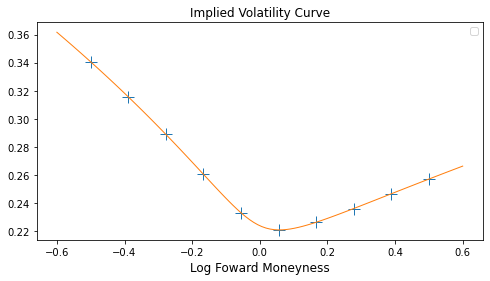

In [42]:
import matplotlib.pyplot as plt

scale = (max(x)-min(x))*.1
lmax,lmin = min(x)-scale,max(x)+scale
lin = np.linspace(lmin,lmax,100)
plt.figure(figsize=(8, 4))
plt.plot(x, np.sqrt(iv), '+', markersize=12)
plt.plot(lin, np.sqrt(svi_raw(lin, fitted_value)),linewidth=1)
plt.title("Implied Volatility Curve")
plt.xlabel("Log Foward Moneyness", fontsize=12)
plt.legend()
plt.show()